# Testing on NGC 6819

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tools import generate_df

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 25,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the NGC 6819 data from Meibom et al. (2016)

In [2]:
ngc = pd.read_csv("data/NGC6819_gaia.csv")
ngc.head()

,Unnamed: 0,source_id,designation,gaia_ref_epoch,ra_gaia,ra_error,dec_gaia,dec_error,parallax,parallax_error,...,kepler_gaia_ang_dist,id,KIC,B-V,prot,prot_err,RAJ2000,DEJ2000,ra_kepler.1,dec_kepler.1
0,0,2076299100558429568,Gaia DR2 2076299100558429568,2015.5,295.282289,0.090736,40.098596,0.106551,0.473887,0.108458,...,0.415715,77.0,4936891,0.85,21.98,0.81,19 41 07.75,40 05 55.0,295.282292,40.098611
1,1,2076298207205146240,Gaia DR2 2076298207205146240,2015.5,295.332888,0.090222,40.094343,0.110077,0.417001,0.108583,...,0.296642,95.0,4937119,0.87,23.28,0.77,19 41 19.90,40 05 39.7,295.332917,40.094361
2,2,2076298211512782208,Gaia DR2 2076298211512782208,2015.5,295.339775,0.077508,40.089181,0.095191,0.036194,0.097730,...,0.215960,99.0,4937149,0.80,21.68,0.63,19 41 21.54,40 05 21.1,295.339750,40.089194
3,3,2076298589469910784,Gaia DR2 2076298589469910784,2015.5,295.344199,0.058558,40.095688,0.072367,0.281128,0.072858,...,0.101142,100.0,4937169,0.70,19.62,NaN,19 41 22.61,40 05 44.6,295.344208,40.095722
4,4,2076295527145521792,Gaia DR2 2076295527145521792,2015.5,295.387877,0.092442,40.086753,0.130432,0.291695,0.124538,...,0.394985,119.0,4937356,0.89,21.23,1.73,19 41 33.09,40 05 12.4,295.387875,40.086778


Calculate the photometric noise.

In [5]:
from tools import photometric_noise

ngc["G"] = ngc["phot_g_mean_mag"]
ngc["bp"] = ngc["phot_bp_mean_mag"]
ngc["rp"] = ngc["phot_rp_mean_mag"]
G_err, bp_err, rp_err, parallax_err = photometric_noise(ngc.G, ngc.bp, ngc.rp)
ngc["G_err"] = G_err
ngc["bp_err"] = bp_err
ngc["rp_err"] = rp_err

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Let's de-redden the photometry using Sergey Koposov's code.

In [7]:
from tools import getDust

AG, Abp, Arp = [np.empty(len(ngc)) for i in range(3)]
for i, G in enumerate(ngc.G):
    AGs, Abps, Arps = getDust(G, ngc.bp[i], ngc.rp[i], .15)
    AG[i], Abp[i], Arp[i] = AGs, Abps, Arps
    
bprp_dered = (ngc.phot_bp_mean_mag - Abp) - (ngc.phot_rp_mean_mag - Arp)

/Users/rangus/projects/stardate/stardate/lhf.py:66: RuntimeWarning: divide by zero encountered in log10
  log10_bprp = np.log10(bprp)


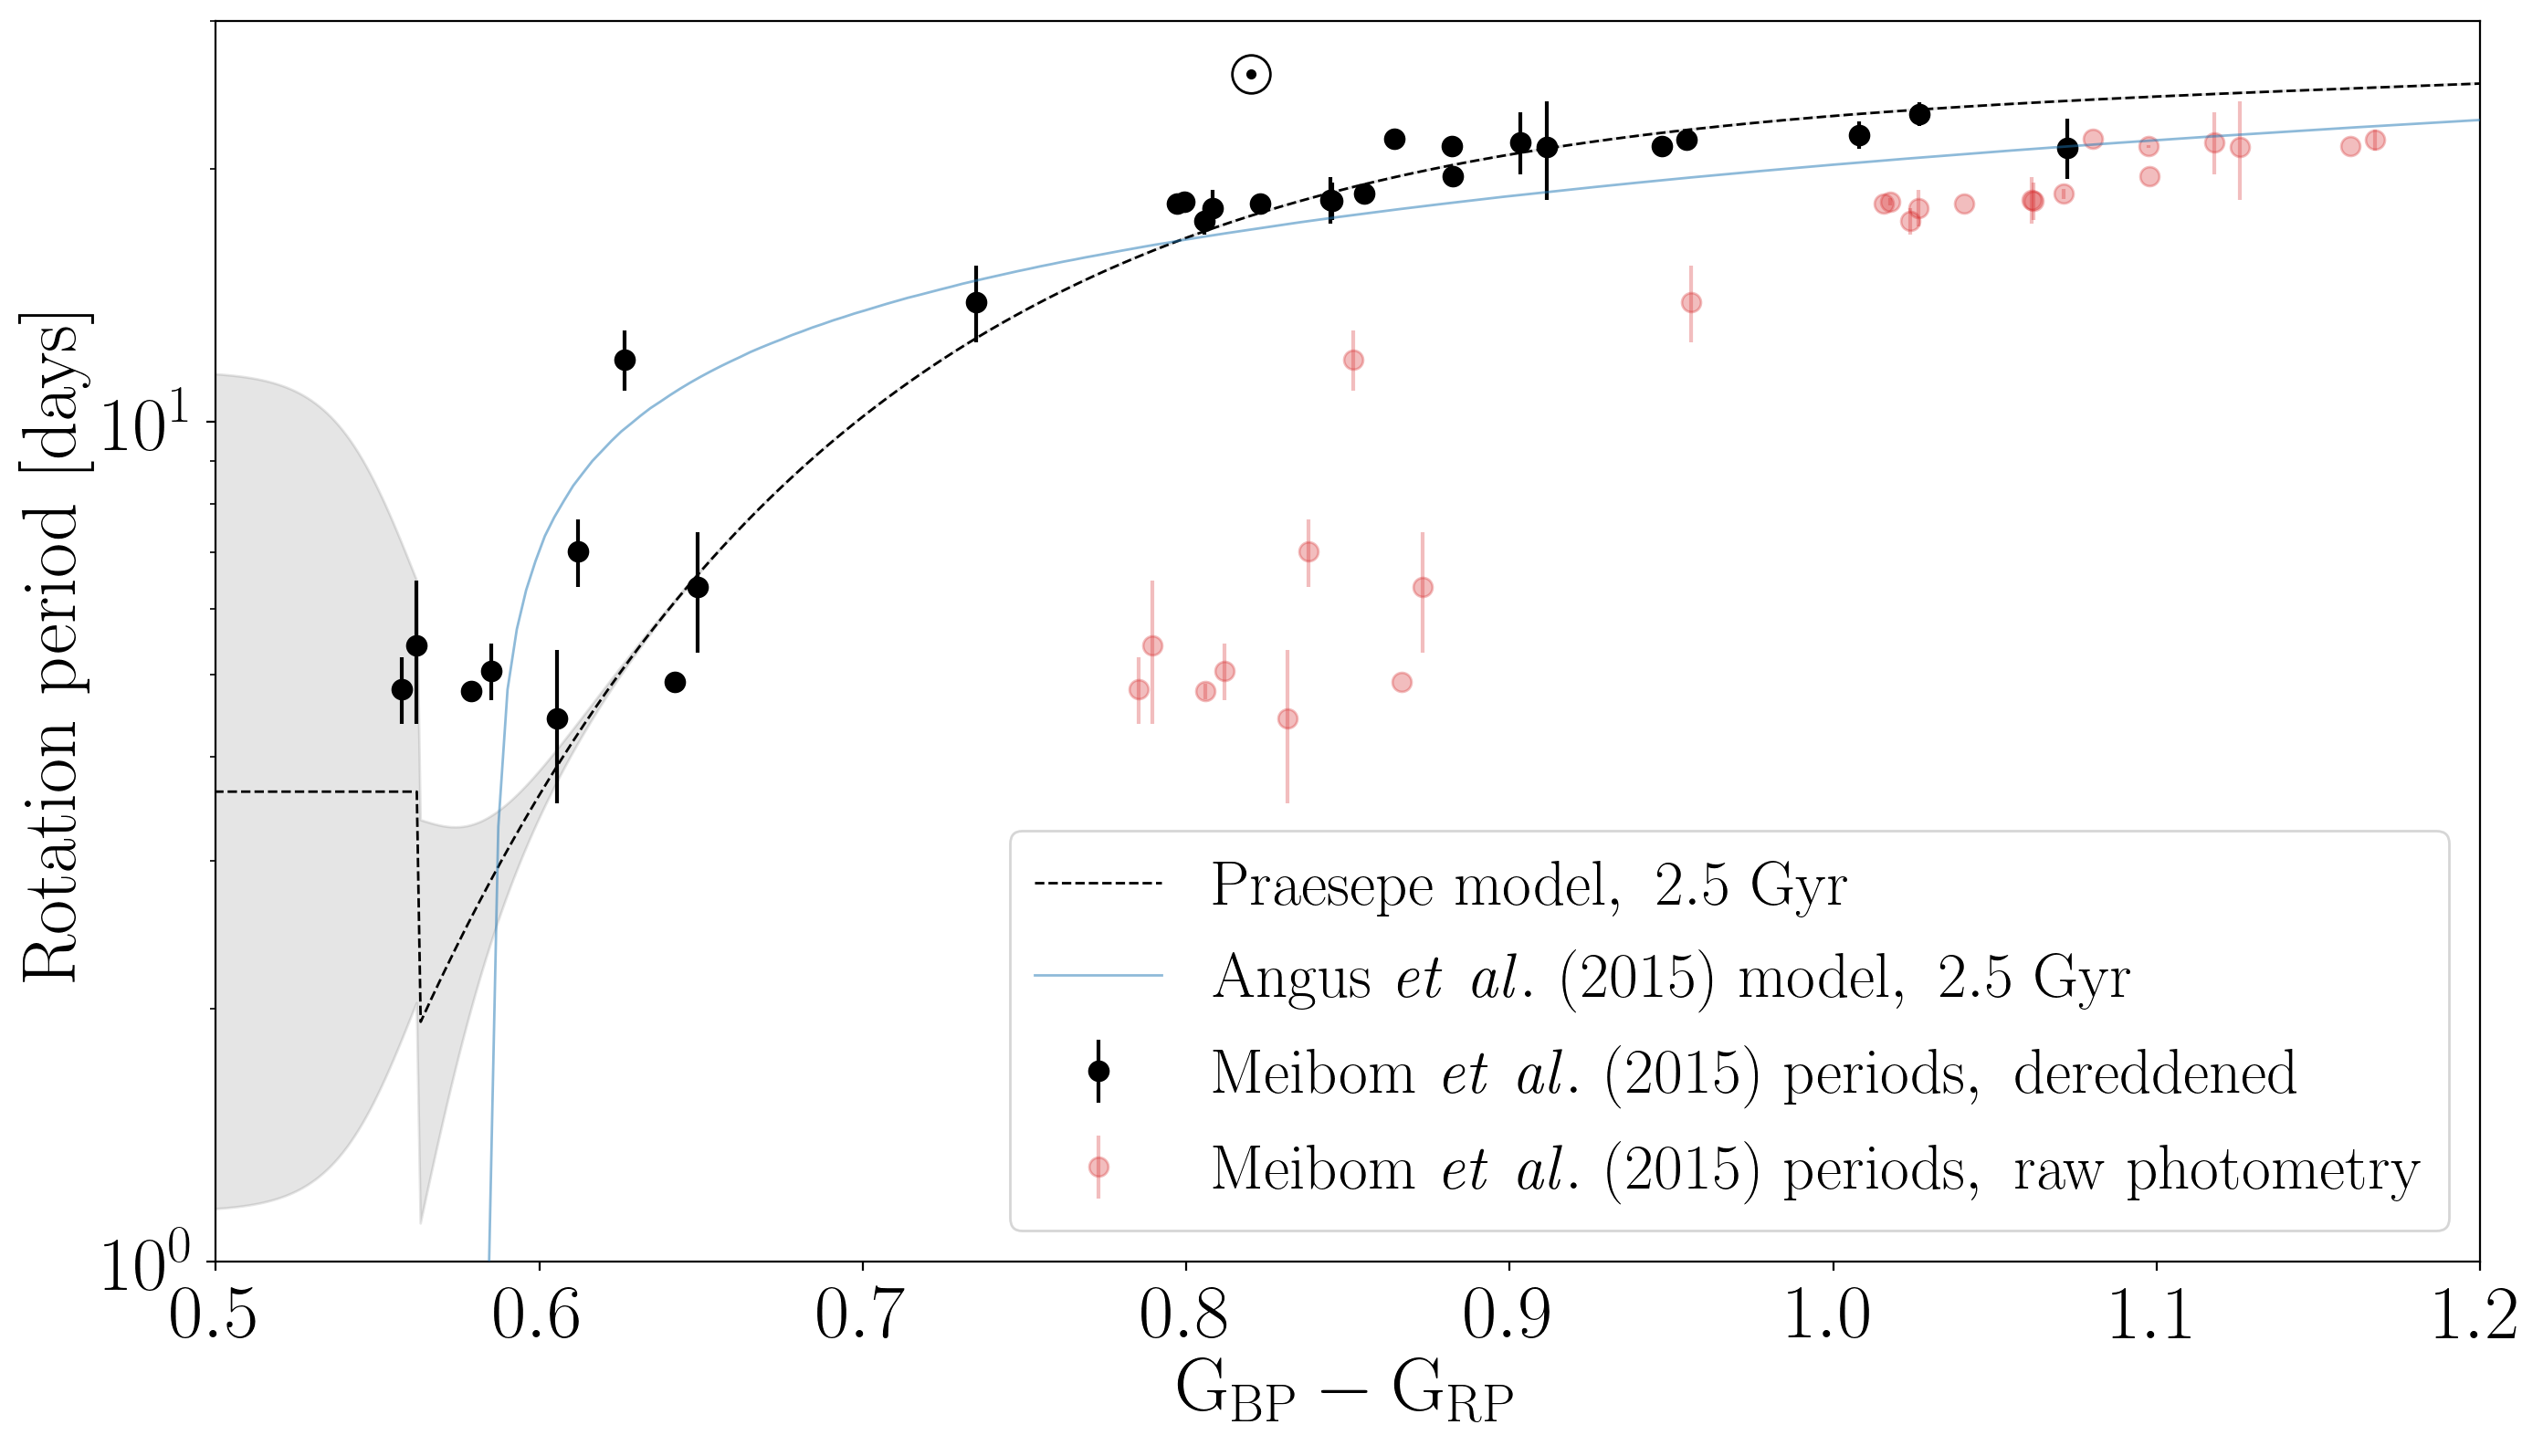

In [77]:
plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar(bprp_dered, ngc.prot, yerr=ngc.prot_err, fmt="k.", ms=15,
             zorder=2, label="$\mathrm{Meibom~{\it et~al.}~(2015)~periods,~dereddened}$", rasterized=True)
plt.errorbar(ngc.phot_bp_mean_mag - ngc.phot_rp_mean_mag, ngc.prot, yerr=ngc.prot_err,
             fmt=".", color="tab:red", ms=15, alpha=.3,
             zorder=2, label="$\mathrm{Meibom~{\it et~al.}~(2015)~periods,~raw~photometry}$", rasterized=True)
# plt.errorbar(bprp_dered, ngc.prot, yerr=ngc.prot*.1, fmt=".", color="C1", ms=15,
#              zorder=0, label="$\mathrm{10\%~uncertainties}$", rasterized=True)

from tools import bprp_2_bv
import stardate.lhf as sdl

# Calculate and plot praesepe model periods
xs = np.linspace(0, 1.2, 1000)
log_periods_praesepe, log_periods_sun, log_sigs = [np.zeros_like(xs) for i in range(3)]
for i, _x in enumerate(xs):
    log_periods_praesepe[i] = sdl.gyro_model_praesepe(np.log10(2.5*1e9), _x)
    log_periods_sun[i] = sdl.gyro_model_praesepe(np.log10(4.56*1e9), _x)
    log_sigs[i] = sdl.sigma(355, 9, 0., _x, model="praesepe")
plt.plot(xs, 10**log_periods_praesepe, color="k", lw=1, ls="--", zorder=3, ms=35, rasterized=True,
        label="$\mathrm{Praesepe~model,~2.5~Gyr}$")
plt.fill_between(xs, 10**(log_periods_praesepe - log_sigs), 
                 10**(log_periods_praesepe + log_sigs), color="k", alpha=.1, rasterized=True)
# plt.plot(xs, 10**log_periods_sun, color="k", lw=1, ls="--", zorder=3, ms=35, rasterized=True)
# plt.fill_between(xs, 10**(log_periods_sun - log_sigs), 
#                  10**(log_periods_sun + log_sigs), color="k", alpha=.1, rasterized=True)

# Calculate and plot Angus (2015) model.
xs = np.linspace(-.134, .2, 200)
bv, log_periods_praesepe, log_periods_sun, log_sigs = [np.zeros_like(xs) for i in range(4)]
for i, _x in enumerate(xs):
    bv[i] = bprp_2_bv(10**_x)
    log_periods_praesepe[i] = sdl.gyro_model(np.log10(2.5*1e9), bv[i])
    log_periods_sun[i] = sdl.gyro_model(np.log10(4.56*1e9), bv[i])
    log_sigs[i] = sdl.sigma(355, 9, 0, bv[i])
plt.plot(10**xs-.15, 10**log_periods_praesepe, color="C0", lw=1, zorder=3, ms=35, rasterized=True,
        label="$\mathrm{Angus~{\it et~al.}~(2015)~model,~2.5~Gyr}$", alpha=.5)
# plt.plot(10**xs-.15, 10**log_periods_sun, color="C0", lw=1, zorder=0, rasterized=True,
#          alpha=.5)

# Plot the Sun
plt.plot(.82, 26, "wo", markeredgecolor="k", ms=15, zorder=3, rasterized=True)
plt.plot(.82, 26, ".k", zorder=3, rasterized=True)

plt.yscale("log")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.ylim(1, 30)
plt.xlim(.5, 1.2)
plt.legend(loc="lower right")
plt.savefig("../NGC6819.pdf")

Save the data to a file to calculate ages with stardate and isochrones.

In [14]:
ngc["G_dered"] = ngc.G - AG
ngc["bp_dered"] = ngc.phot_bp_mean_mag - Abp
ngc["rp_dered"] = ngc.phot_rp_mean_mag - Arp

ngc.to_csv("data/ngc6819_err.csv")

Load the resulting ages (after running code on the cluster).

In [69]:
from tools import read_files

age_samps, ages, errp, errm, std, inds = read_files("praesepe_stardate", ngc.KIC.values,
                                                    "NGC6819_results", zf=9)
bprps = ngc.bp_dered.values[inds] - ngc.rp_dered.values[inds]

age_samps5, ages5, errp5, errm5, std5, inds5 = read_files("praesepe_stardate_5", ngc.KIC.values,
                                                    "NGC6819_results", zf=9)
bprps5 = ngc.bp_dered.values[inds5] - ngc.rp_dered.values[inds5]

age_samps_red, ages_red, errp_red, errm_red, std_red, inds_red = read_files("praesepe_stardate", ngc.KIC.values,
                                                    "NGC6819_results/old", zf=9)
bprps_red = ngc.bp_dered.values[inds_red] - ngc.rp_dered.values[inds_red]

age_samps_a, ages_a, errp_a, errm_a, std_a, inds_a = read_files("angus15_stardate", ngc.KIC.values,
                                                    "NGC6819_results", zf=9)
bprps_a = ngc.bp_dered.values[inds_a] - ngc.rp_dered.values[inds_a]

age_samps_i, ages_i, errp_i, errm_i, std_i, inds_i = read_files("iso", ngc.KIC.values,
                                                    "NGC6819_results", zf=9)
bprps_i = ngc.bp_dered.values[inds_i] - ngc.rp_dered.values[inds_i]

Plot the results.

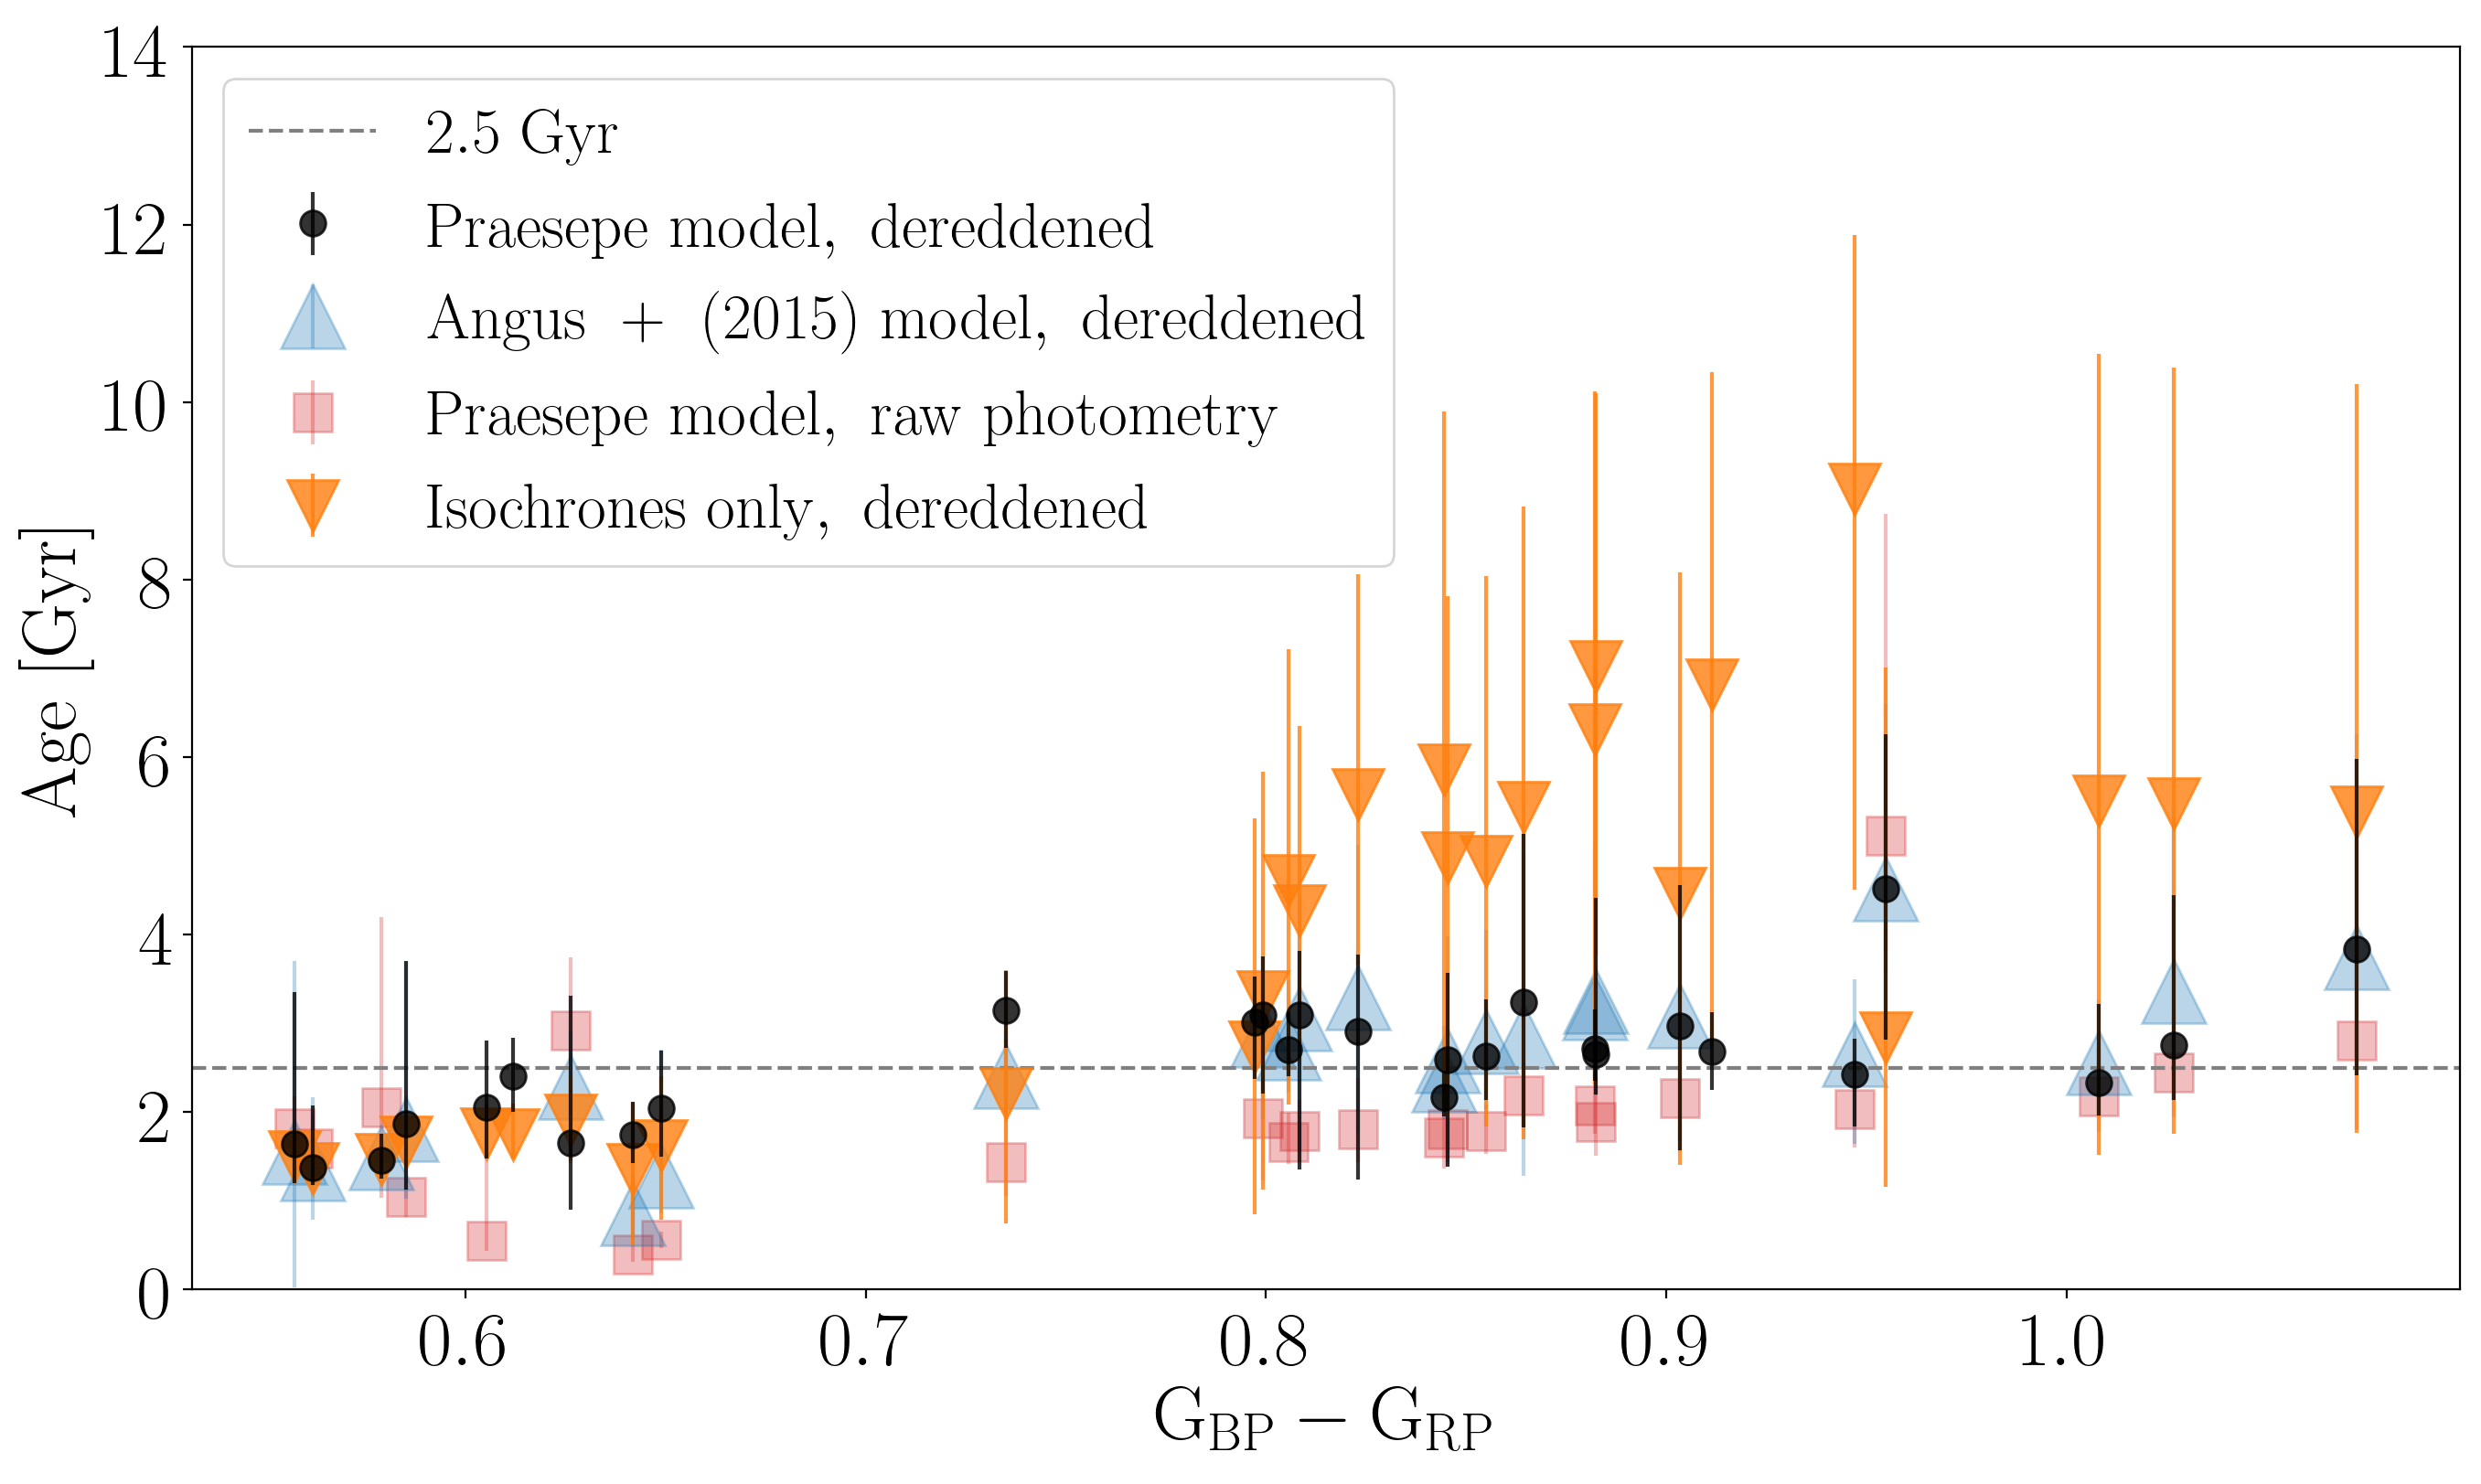

In [141]:
plt.figure(figsize=(16, 9), dpi=200)
# plt.errorbar(bprps, ages, yerr=[errm, errp], fmt="C0.", ms=20, alpha=.8, color="k",
#             label="$\mathrm{Praesepe~model,~dereddened}$", zorder=4)
plt.errorbar(bprps5, ages5, yerr=[errm5, errp5], fmt=".", ms=20, alpha=.8, color="k",
            label="$\mathrm{Praesepe~model,~dereddened}$", zorder=4)
plt.errorbar(bprps_a, ages_a, yerr=[errm_a, errp_a], fmt="^", ms=25, color="C0",
            label="$\mathrm{Angus~+~(2015)~model,~dereddened}$", zorder=1, alpha=.3)
plt.errorbar(bprps_red, ages_red, yerr=[errm_red, errp_red], fmt="s", color="tab:red", ms=15,
            label="$\mathrm{Praesepe~model,~raw~photometry}$", zorder=0, alpha=.3)
plt.errorbar(bprps_i, ages_i, yerr=[errm_i, errp_i], fmt="v", color="C1", ms=20,
            label="$\mathrm{Isochrones~only,~dereddened}$", zorder=3, alpha=.8)
plt.axhline(2.5, color=".5", ls="--", label="$\mathrm{2.5~Gyr}$")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{Age~[Gyr]}$")
plt.legend(loc="upper left")
plt.ylim(0, 14)
plt.savefig("../NGC6819_results.pdf")

Calculate summary statistics.

In [134]:
def rerr_log(samps):
    relerr = []
    for i in range(len(samps)):
        relerr.append(np.std(np.log10(samps[i]*1e9))*100/.434)
    return np.array(relerr)

def rerr(samps):
    relerr = []
    for i in range(len(samps)):
        relerr.append(np.std(samps[i])*100)
    return np.array(relerr)

print("{0:.2f} % uncertainty".format(np.median(rerr(age_samps5))))
print("{0:.2f} % uncertainty".format(np.median(rerr(age_samps_i))))

# print(max(np.std(age_samps5)), min(errp5/ages5*100), np.mean(errp5/ages5*100), np.median(errp5/ages5*100))
# print(max(std_i/ages_i*100), min(std_i/ages_i*100), np.mean(std_i/ages_i*100), np.median(std_i/ages_i*100))

154.73 % uncertainty
222.89 % uncertainty


In [106]:
def SE(x):
    return np.std(x)/np.sqrt(len(x)) #* 1.25

def RMS(mean, x):
    return np.sqrt(np.mean((x - mean)**2))

print("10% uncertainty: {0:.2f} \pm {1:.2f}, precision = {2:.2f} %".format(
    np.average(ages, weights=1./(std)**2), SE(ages), 100*SE(ages)/np.average(ages, weights=1./(std)**2)))
print("5% uncertainty: {0:.2f} \pm {1:.2f}, precision = {2:.2f} %".format(
    np.average(ages5, weights=1./(std5)**2), SE(ages5), 100*SE(ages)/np.average(ages, weights=1./(std)**2)))
print("Iso: {0:.2f} \pm {1:.2f}".format(np.average(ages_i, weights=1./(std_i)**2), SE(ages_i)))
print("reddening: {0:.2f} \pm {1:.2f}".format(np.average(ages_red, weights=1./(std_red)**2), SE(ages_red)))
print("angus: {0:.2f} \pm {1:.2f}".format(np.average(ages_a, weights=1./(std_a)**2), SE(ages_a)))

print("\nPresepe model precision = {0:.2f} +\- {1:.2f}, Gyr, RMS = {2:.2f} Gyr, {3:.2f} %".format(
    np.median(ages), SE(ages)*1.25, RMS(2.5, ages), 100*(SE(ages)*1.25)/np.median(ages)))
print("Presepe 5% model precision = {0:.2f} +\- {1:.2f}, Gyr, RMS = {2:.2f} Gyr, {3:.2f} %".format(
    np.median(ages5), SE(ages5)*1.25, RMS(2.5, ages5), 100*(SE(ages)*1.25)/np.median(ages)))
print("Angus + (2015) model precision = {0:.2f} +\- {1:.2f}, Gyr, RMS = {2:.2f} Gyr".format(
    np.median(ages_a), SE(ages_a)*1.25, np.sqrt(np.sum((ages_a-2.5)**2))))
print("Presepe model raw phot precision = {0:.2f} +\- {1:.2f}, Gyr, RMS = {2:.2f} Gyr".format(
    np.median(ages_red), SE(ages_red)*1.25, np.sqrt(np.sum((ages_red-2.5)**2))))
print("Isochrones only precision = {0:.2f} +\- {1:.2f}, Gyr, RMS = {2:.2f} Gyr".format(
    np.median(ages_i), SE(ages_i)*1.25, np.sqrt(np.sum((ages_i-2.5)**2))))

103.82641996256383 0.02383149338287899 37.857712299446376 29.59388361099002
108.09475082481255 0.019964148346591496 47.10329425353388 51.61715354755915
10% uncertainty: 2.50 \pm 0.12, precision = 4.84 %
5% uncertainty: 2.50 \pm 0.13, precision = 4.84 %
Iso: 2.50 \pm 0.39
reddening: 2.50 \pm 0.17
angus: 2.50 \pm 0.16

Presepe model precision = 2.82 +\- 0.15, Gyr, RMS = 0.66 Gyr, 5.36 %
Presepe 5% model precision = 2.63 +\- 0.16, Gyr, RMS = 0.69 Gyr, 5.36 %
Angus + (2015) model precision = 2.66 +\- 0.21, Gyr, RMS = 4.12 Gyr
Presepe model raw phot precision = 1.86 +\- 0.22, Gyr, RMS = 5.34 Gyr
Isochrones only precision = 4.27 +\- 0.48, Gyr, RMS = 13.51 Gyr


2.823571838371609 2.5400295349645203 4.270125884456585
0.17791693970822034 0.4816269706255461
Presepe model precision = 1.70 Gyr, RMS = 3.58 Gyr
Presepe 5% model precision = 1.35 Gyr, RMS = 3.42 Gyr
Angus + (2015) model precision = 1.76 Gyr, RMS = 4.12 Gyr
Presepe model raw phot precision = 1.24 Gyr, RMS = 5.34 Gyr
Isochrones only precision = 2.23 Gyr, RMS = 13.51 Gyr

Load NGC6811 too, although since the reddening values are uncertain this won't go into the paper.

In [25]:
ngc11 = pd.read_csv("data/NGC6811_gaia.csv")

# Deredden
AG11, Abp11, Arp11 = [np.empty(len(ngc11)) for i in range(3)]
for i, G in enumerate(ngc11.phot_g_mean_mag):
    AGs, Abps, Arps = getDust(G, ngc11.phot_bp_mean_mag[i], ngc11.phot_rp_mean_mag[i], .05)
    AG11[i], Abp11[i], Arp11[i] = AGs, Abps, Arps
    
bprp11_dered = (ngc11.phot_bp_mean_mag - Abp11) - (ngc11.phot_rp_mean_mag - Arp11)

/Users/rangus/projects/stardate/stardate/lhf.py:66: RuntimeWarning: divide by zero encountered in log10
  log10_bprp = np.log10(bprp)


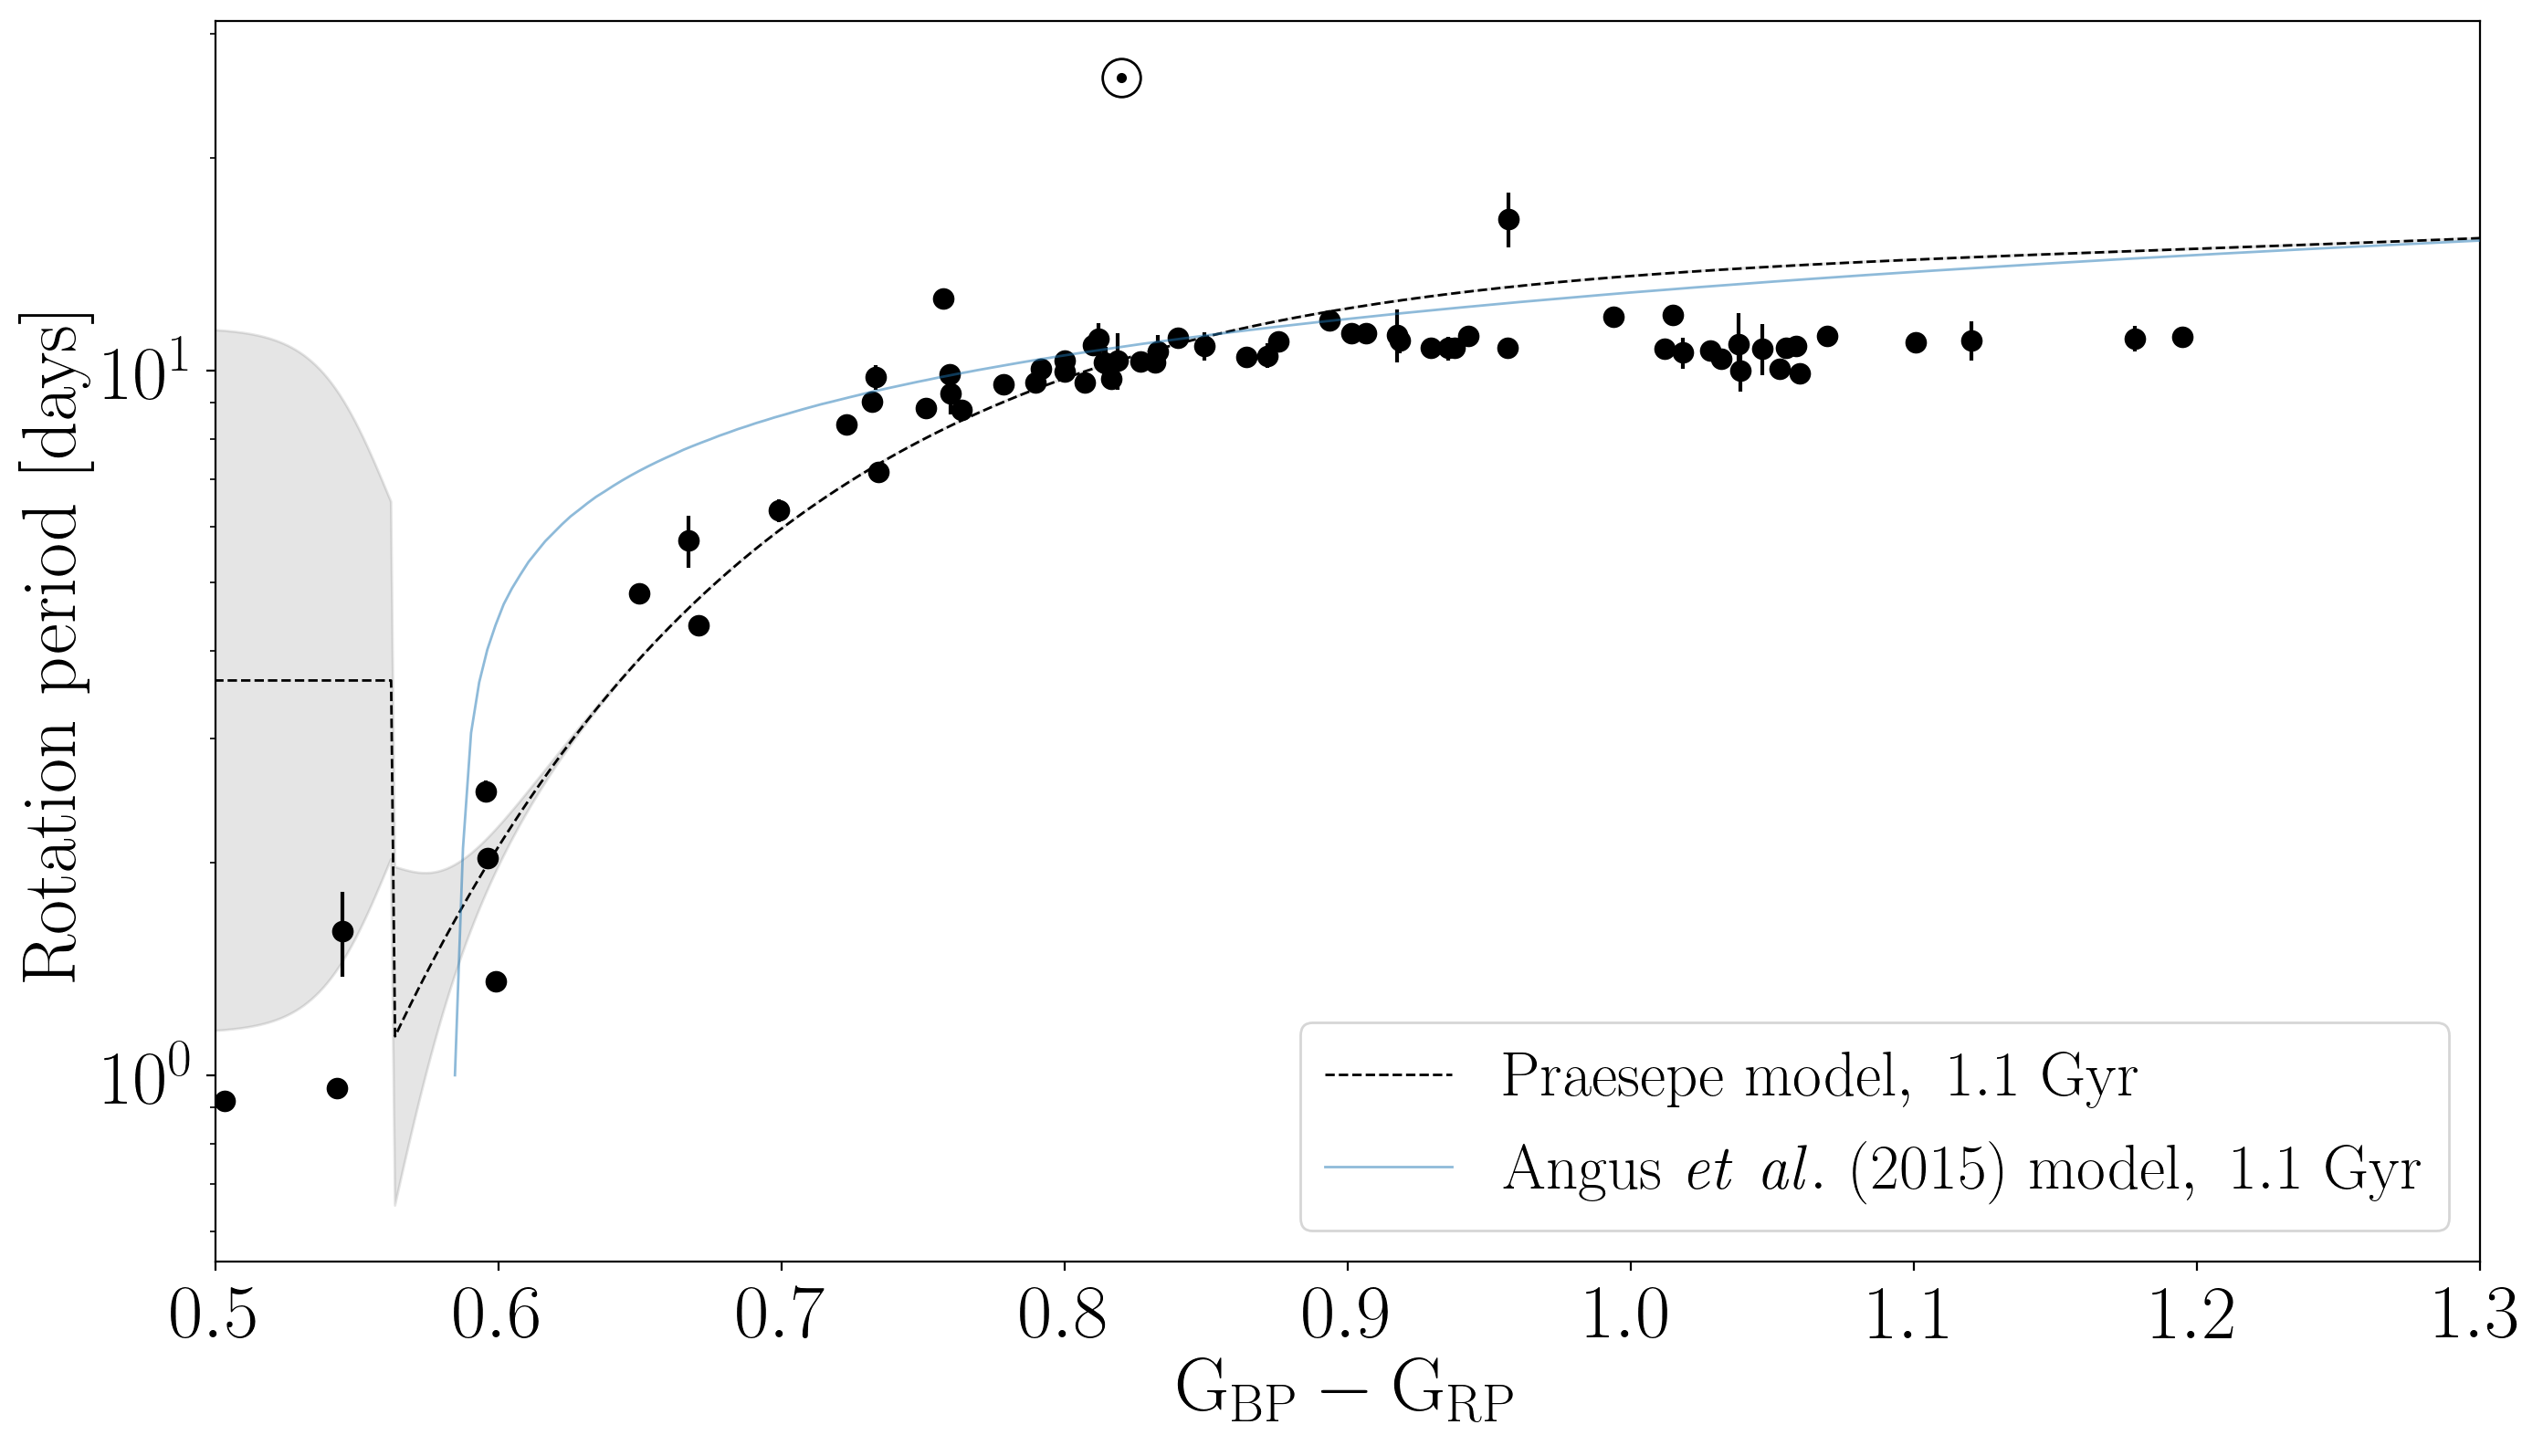

In [29]:
plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar(bprp11_dered, ngc11.Per, yerr=ngc11.e_Per,
             fmt="k.", ms=15, zorder=2, label=None, rasterized=True)

xs = np.linspace(0, 1.4, 1000)
log_periods_praesepe, log_periods_sun, log_sigs = [np.zeros_like(xs) for i in range(3)]
for i, _x in enumerate(xs):
    log_periods_praesepe[i] = sdl.gyro_model_praesepe(np.log10(1.1*1e9), _x)
    log_periods_sun[i] = sdl.gyro_model_praesepe(np.log10(4.56*1e9), _x)
    log_sigs[i] = sdl.sigma(355, 9, 0., _x, model="praesepe")
    
plt.plot(xs, 10**log_periods_praesepe, color="k", lw=1, ls="--", zorder=3, ms=35, rasterized=True,
        label="$\mathrm{Praesepe~model,~1.1~Gyr}$")
plt.fill_between(xs, 10**(log_periods_praesepe - log_sigs), 
                 10**(log_periods_praesepe + log_sigs), color="k", alpha=.1, rasterized=True)
# plt.plot(xs, 10**log_periods_sun, color="k", lw=1, ls="--", zorder=3, ms=35, rasterized=True)
# plt.fill_between(xs, 10**(log_periods_sun - log_sigs), 
#                  10**(log_periods_sun + log_sigs), color="k", alpha=.1, rasterized=True)

# Plot Angus (2015) model.
xs = np.linspace(-.134, .2, 200)
bv, log_periods_praesepe, log_periods_sun, log_sigs = [np.zeros_like(xs) for i in range(4)]
for i, _x in enumerate(xs):
    bv[i] = bprp_2_bv(10**_x)
    log_periods_praesepe[i] = sdl.gyro_model(np.log10(1.1*1e9), bv[i])
    log_periods_sun[i] = sdl.gyro_model(np.log10(4.56*1e9), bv[i])
    log_sigs[i] = sdl.sigma(355, 9, 0, bv[i])

plt.plot(10**xs-.15, 10**log_periods_praesepe, color="C0", lw=1, zorder=3, ms=35, rasterized=True,
        label="$\mathrm{Angus~{\it et~al.}~(2015)~model,~1.1~Gyr}$", alpha=.5)
# plt.plot(10**xs-.15, 10**log_periods_sun, color="C0", lw=1, zorder=0, rasterized=True,
#          alpha=.5)

plt.plot(.82, 26, "wo", markeredgecolor="k", ms=15, zorder=3, rasterized=True)
plt.plot(.82, 26, ".k", zorder=3, rasterized=True)

plt.xlabel("$\mathrm{G_{BP}-G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
# plt.ylim(0, 18)
plt.yscale("log")
plt.xlim(.5, 1.3)
plt.legend()